## Libraries

# **Tabular Playground Series - Sep 2022**
### Predicting a full year worth of sales

<img width="300" src="https://historia.nationalgeographic.com.es/medio/2017/06/26/nostradamus_1439x2000_11877630.JPG">

Here we go...

## Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import pandas as pd
import numpy as np

## Load Data

In [2]:
train_dataset = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv',
                           parse_dates=['date'])
test_dataset = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

## Visualize per Product

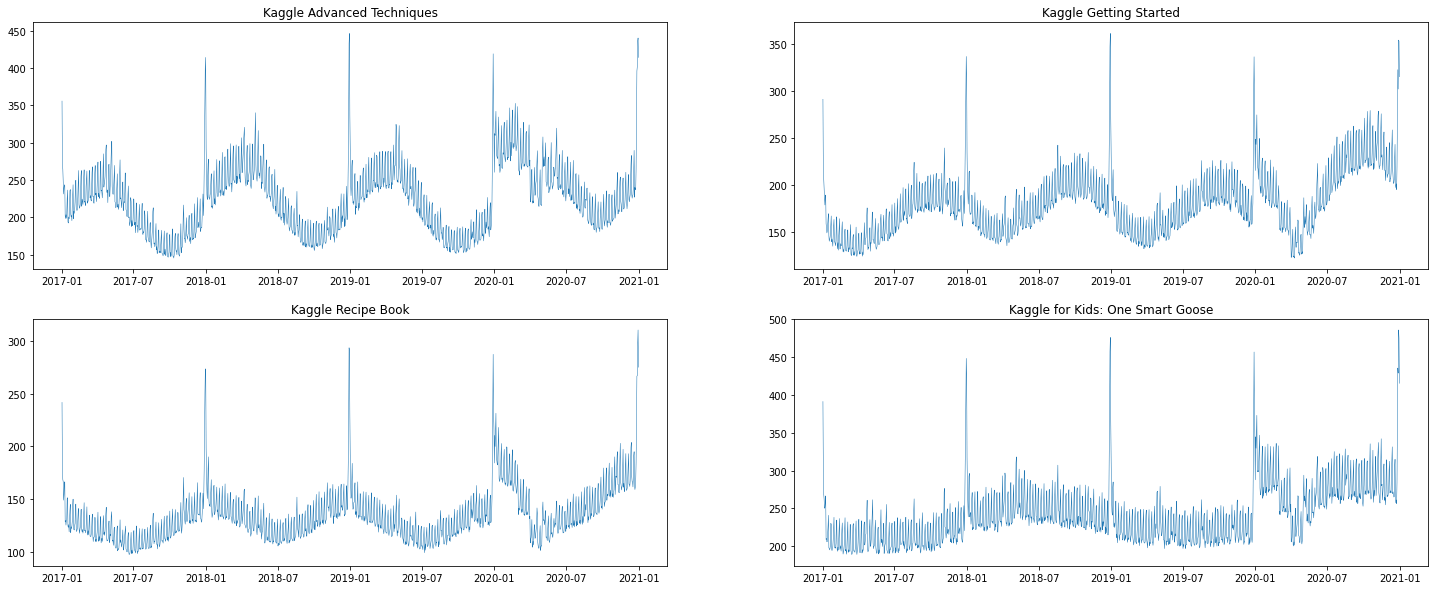

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25,10))

for i, product in enumerate(train_dataset["product"].unique()):
    train_test = train_dataset.loc[(train_dataset['product'] == product)].copy()
    train_test = train_test.groupby('date').mean()
    ax[i//2,i%2].plot(train_test.index, train_test.num_sold, linewidth=1/2)
    ax[i//2,i%2].set(title=product)

In [4]:
product_dataset = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv',
                           dtype={
                               "country": "category",
                               "store": "category",
                               "num_sold": "float32"
                           },
                           parse_dates=['date'],
                           infer_datetime_format=True)
# Hands on time stamps:
product_dataset['date'] = product_dataset.date.dt.to_period('D')
product_dataset = product_dataset.set_index(['country', 'store', 'product', 'date']).sort_index()
product_dataset

row_id  \
country store      product                          date                 
Belgium KaggleMart Kaggle Advanced Techniques       2017-01-01       0   
                                                    2017-01-02      48   
                                                    2017-01-03      96   
                                                    2017-01-04     144   
                                                    2017-01-05     192   
...                                                                ...   
Spain   KaggleRama Kaggle for Kids: One Smart Goose 2020-12-27   69935   
                                                    2020-12-28   69983   
                                                    2020-12-29   70031   
                                                    2020-12-30   70079   
                                                    2020-12-31   70127   

                                                                num_sold  
country store      product                          date                  
Belgium KaggleMart Kaggle Advanced Techniques       2017-01-01     663.0  
                                                    2017-01-02     514.0  
                                                    2017-01-03     549.0  
                                                    2017-01-04     477.0  
                                                    2017-01-05     447.0  
...                                                                  ...  
Spain   KaggleRama Kaggle for Kids: One Smart Goose 2020-12-27     204.0  
                                                    2020-12-28     212.0  
                                                    2020-12-29     242.0  
                                                    2020-12-30     239.0  
                                                    2020-12-31     202.0  

[70128 rows x 2 columns]

In [5]:
y = product_dataset.unstack(['country', 'store', 'product'])

# Create training data
fourier = CalendarFourier(freq='A', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True)
X = dp.in_sample()
X["NewYear"] = (X.index.dayofyear == 364)

model = LinearRegression(fit_intercept=True)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

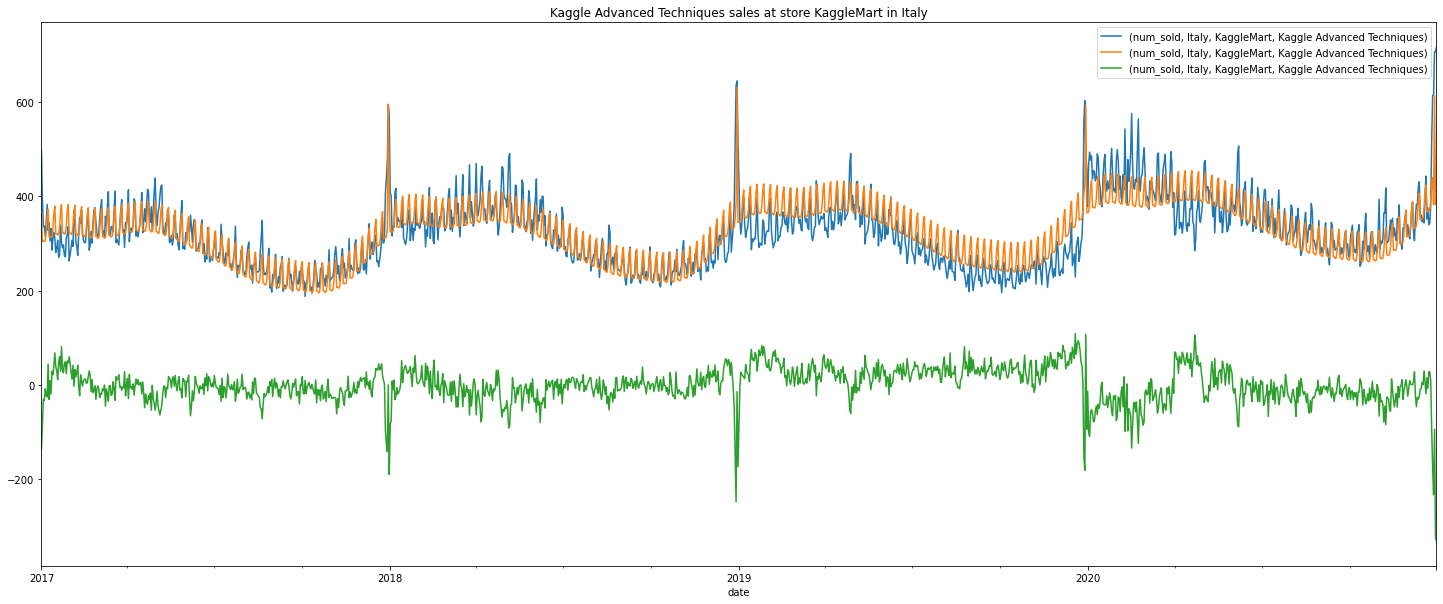

In [6]:
country='Italy'
store='KaggleMart'
product='Kaggle Advanced Techniques'

fig,ax = plt.subplots(figsize=(25,10))
ax=y.loc(axis=1)['num_sold', country, store, product].plot(ax=ax)
ax=y_pred.loc(axis=1)['num_sold', country, store, product].plot(ax=ax)
ax=(y_pred.loc(axis=1)['num_sold', country, store, product]-y.loc(axis=1)['num_sold', country, store, product]).plot(ax=ax)
ax.set_title(f'{product} sales at store {store} in {country}')
ax.legend();

In [7]:
test_df = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv',
                           dtype={
                               "country": "category",
                               "store": "category",
                               "num_sold": "float32"
                           },
                           parse_dates=['date'],
                           infer_datetime_format=True)
# Periodicity
test_df['date'] = test_df.date.dt.to_period('D')
test_df = test_df.set_index(['country', 'store', 'product', 'date']).sort_index()

# New Year Feature
X_test = dp.out_of_sample(steps=365)
X_test.index.name = 'date'
X_test["NewYear"] = (X_test.index.dayofyear == 364)

## Submission

In [8]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['country', 'store', 'product'])
y_submit = y_submit.join(test_df.set_index("row_id"), on="row_id").reindex(columns=['row_id', 'num_sold'])
y_submit['row_id'] = np.floor(pd.to_numeric(y_submit['row_id'], errors='coerce')).astype('Int64')
y_submit.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1208: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
